# COVID REPORTING KOENVS

## Imports

In [16]:
import urllib3
import pandas as pd
import bs4
from pathlib import Path
from json import loads
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math
import numpy as np

mpl.rcParams["figure.figsize"] = 10,8
mpl.rcParams["axes.grid"] = True
mpl.rcParams["axes.grid.which"] = "both"
mpl.style.use("ggplot")

## Get data from Sciensano

Gets page from Sciensano with data storage links, use bs4 to look for resources ending in JSON and CSV. CSV is more efficient to pull so all datasets are downloaded and converted to pd.DataFrames. At the end, downloaded dataset are shown with columns printed. First data is filtered (remove French and incomplete rows)

In [3]:
http = urllib3.PoolManager()
r = http.request("GET", "https://epistat.wiv-isp.be/covid/")
page = bs4.BeautifulSoup(r.data.decode("utf8"), 'html.parser')
links = list(map(lambda x: x.get("href"), page.find_all("a")))
json_links = []
csv_links = []
for link in links:
    temp = Path(link)
    if temp.suffix == ".json":
        json_links.append((temp.name.rstrip(temp.suffix), link))
    elif temp.suffix == ".csv":
        csv_links.append((temp.name.rstrip(temp.suffix), link))
csv_links
dict_df = {}
p1 = re.compile("fr", re.IGNORECASE)
p2 = re.compile("nr_reporting", re.IGNORECASE)
for x, y in csv_links:
    # pandas has build in url fetching/getting, no need for BS4 in this case
    # no_na = pd.read_json(y).dropna(axis = 0) # 1.4 seconds
    # 700 ms (faster less overhead than json)   
    try:
        no_na = pd.read_csv(y, parse_dates=["DATE"], dayfirst=True, ).dropna(axis=0, how="any")
    except ValueError:
        print(f"{x}: no column with date found")
        no_na = pd.read_csv(y).dropna(axis=0, how="any")
    for e in no_na.columns:
        m1 = re.search(p1, e)
        m2 = re.search(p2, e)
        if m1 or m2:
            no_na.drop(e, axis=1, inplace=True)
    dict_df[x] = no_na.convert_dtypes()
print("----------------------")
for i, [k, v] in enumerate(dict_df.items()):
    print(f"Dataset {i+1}:\n\tName: {k}\n\tColumns: ", end = "")
    for j, x in enumerate(v):
        if (j+1) != len(v.columns):
            print(f"{x}, ", end = "")
        else:
            print(f"{x}")
    print(f"\tShape: {v.shape}")

COVID19BE_CASES_MUNI_CUM: no column with date found
----------------------
Dataset 1:
	Name: COVID19BE_CASES_AGESEX
	Columns: DATE, PROVINCE, REGION, AGEGROUP, SEX, CASES
	Shape: (44692, 6)
Dataset 2:
	Name: COVID19BE_CASES_MUNI_CUM
	Columns: NIS5, TX_DESCR_NL, TX_ADM_DSTR_DESCR_NL, PROVINCE, REGION, CASES
	Shape: (581, 6)
Dataset 3:
	Name: COVID19BE_CASES_MUNI
	Columns: NIS5, DATE, TX_DESCR_NL, TX_ADM_DSTR_DESCR_NL, PROVINCE, REGION, CASES
	Shape: (82224, 7)
Dataset 4:
	Name: COVID19BE_HOSP
	Columns: DATE, PROVINCE, REGION, TOTAL_IN, TOTAL_IN_ICU, TOTAL_IN_RESP, TOTAL_IN_ECMO, NEW_IN, NEW_OUT
	Shape: (3234, 9)
Dataset 5:
	Name: COVID19BE_MORT
	Columns: DATE, REGION, AGEGROUP, SEX, DEATHS
	Shape: (3689, 5)
Dataset 6:
	Name: COVID19BE_test
	Columns: DATE, PROVINCE, REGION, TESTS_ALL, TESTS_ALL_POS
	Shape: (3388, 5)


## Data in function of age

### Data Processing

In [17]:
grouped = dict_df["COVID19BE_CASES_AGESEX"].groupby(by=["DATE", "AGEGROUP"]).sum()
final = grouped.unstack().CASES.fillna(0)
groups = sorted(dict_df["COVID19BE_CASES_AGESEX"]["AGEGROUP"].unique())

### Plotting

(array(18444.), 18629.0)

<Figure size 720x576 with 0 Axes>

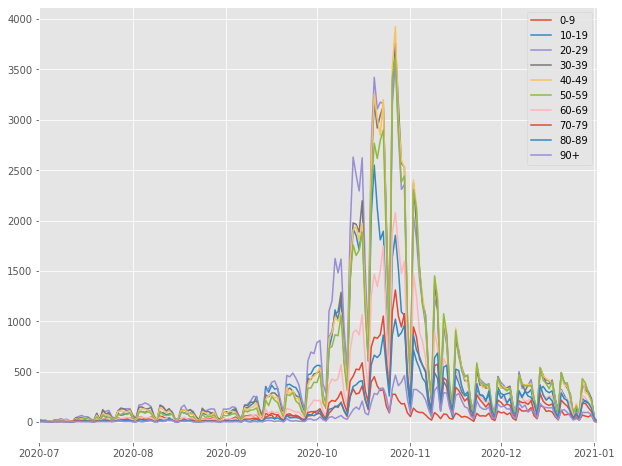

In [18]:
plt.clf()
fig, ax = plt.subplots(1, 1)
for e in groups:
    ax.plot(final[e].index, list(final[e]), label=f"{e}")
ax.legend()
ax.set_xlim(["2020-07-01", final.index[len(final.index)-1]])

(array(18444.), 18629.0)

<Figure size 720x576 with 0 Axes>

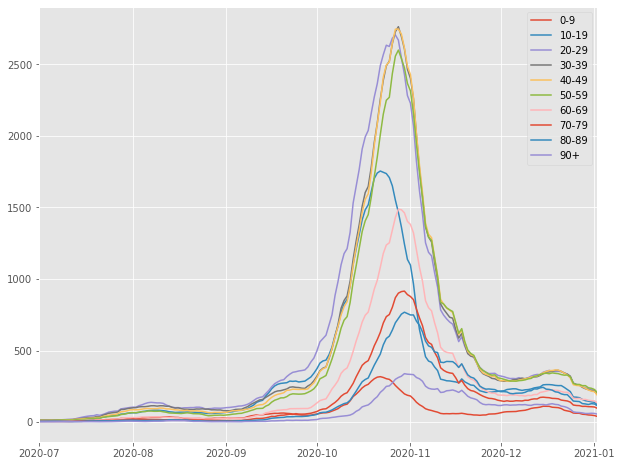

In [19]:
plt.clf()
fig, ax = plt.subplots(1, 1)
for e in groups:
    temp = final[e].rolling(7, min_periods=1).mean()
    temp.apply(int)
    ax.plot(final[e].index, temp, label=f"{e}")
ax.legend()
ax.set_xlim(["2020-07-01", final.index[len(final.index)-1]])

<Figure size 720x576 with 0 Axes>

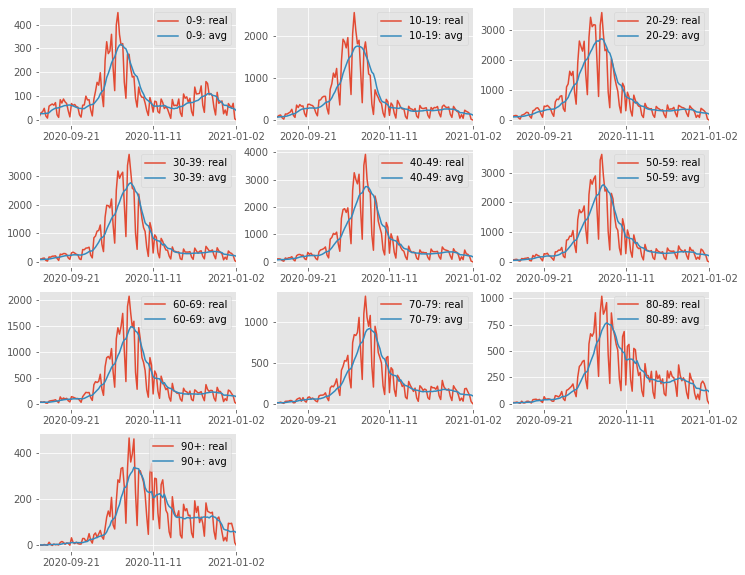

In [20]:
plt.clf()
fig = plt.figure(figsize=(12,10))
num = 6
xt = [final.index[(len(final.index)-1)*x//num] for x in range(1,num+1)]
for i, e in enumerate(groups):
    temp = final[e]
    length = len(groups) + 1
    row = i // (length // 3)
    col = i % 3
    ax = plt.subplot2grid((math.ceil(length/3), 3), (row, col))
    ax.plot(final.index, list(final[e]), label=f"{e}: real")
    ax.plot(final.index, list(final[e].rolling(7, min_periods=1).mean()), label=f"{e}: avg")
    ax.legend()
    ax.set_xticks(xt) # needs to come before limiting with xlim
    ax.set_xlim(["2020-09-01", final.index[len(final.index)-1]])  

In [21]:
# SELF MADE "ROLLING" function (deprecated)
def running_avg(col, days):
    cumsum = 0
    res = []
    for i, x in enumerate(col):
        if i == 0:
            res.append(0)
        elif i < days:
            cumsum += x
            res.append(cumsum/i)
        else:
            cumsum += x
            cumsum -= col[i-days]
            res.append(cumsum/days)
    return res

## Data regarding hospitalizations

### Data Processing

In [22]:
hosp = dict_df["COVID19BE_HOSP"].groupby(by="DATE").sum()
diff = hosp.apply(lambda x: x.diff(), axis = 0).fillna(method="bfill")
result = hosp.join(diff, lsuffix="_org", rsuffix="_org_deriv")
result["DATE"] = result.index
result = result.set_index(np.arange(len(result)))
result["TOTAL_IN_avg"] = result.TOTAL_IN_org.rolling(7, min_periods=1).mean().apply(int)
result["TOTAL_IN_avg_deriv"] = result.TOTAL_IN_avg.diff().fillna(method="bfill")
tot_in = result[["DATE", "TOTAL_IN_org", "TOTAL_IN_org_deriv", "TOTAL_IN_avg", "TOTAL_IN_avg_deriv"]]

### Plotting

(array(18444.), 18629.0)

<Figure size 720x576 with 0 Axes>

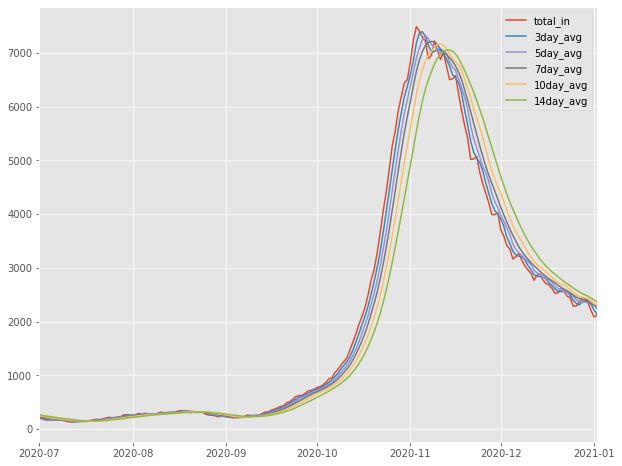

In [23]:
plt.clf()
fig, ax = plt.subplots(1, 1)
ax.plot(hosp.index, list(hosp.TOTAL_IN), label="total_in")
avg_days = [3, 5, 7, 10, 14]
for a in avg_days:
    ax.plot(hosp.index, hosp.TOTAL_IN.rolling(a, min_periods=1).mean().apply(int), label=f"{a}day_avg")
ax.legend()
ax.set_xlim(["2020-07-01", final.index[len(final.index)-1]])

<AxesSubplot:xlabel='DATE'>

<Figure size 720x576 with 0 Axes>

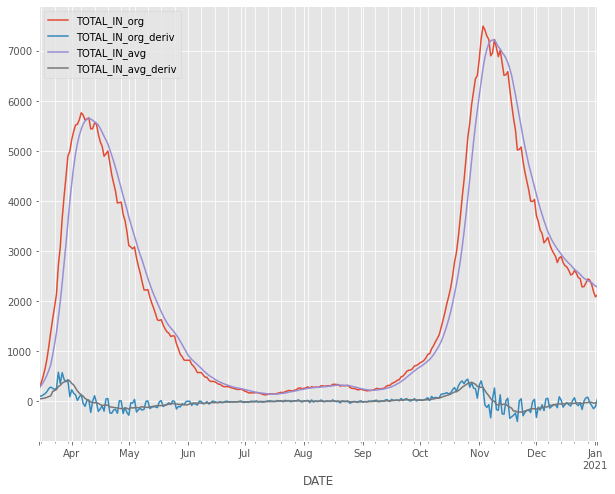

In [24]:
plt.clf()
cols = list(tot_in.columns)
cols.remove("DATE")
tot_in.plot("DATE", cols)
# plt.xlim(["2020-07-01", final.index[len(final.index)-1]])

## Data related to region

### Data processing

In [25]:
temp, cleaned, arr_leuven = None, None, None
temp = dict_df["COVID19BE_CASES_MUNI"]
temp.loc[temp["CASES"] == "<5", "CASES"] = "5"
arr_leuven = temp[temp.TX_ADM_DSTR_DESCR_NL.str.contains("Leuven")]
cleaned = arr_leuven.astype({"CASES": "Int32"})

### Plotting

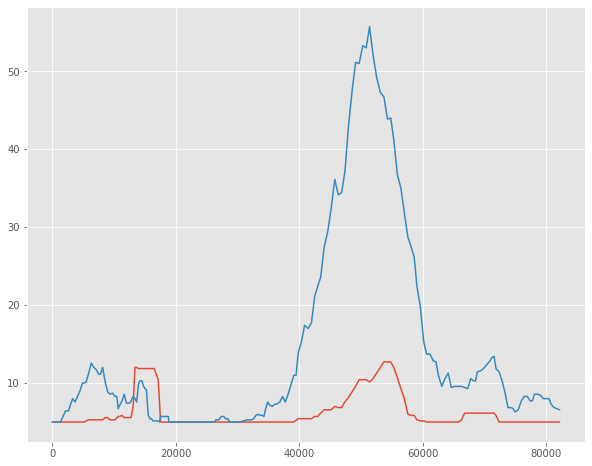

In [26]:
li = ["Herent", "Leuven"]
plt.clf()
# fig, ax = plt.subplots(1, 1)
for x in li:
    temp = cleaned[cleaned.TX_DESCR_NL.str.contains(x)]
    pl = temp.CASES.rolling(7, min_periods=1).mean()
    pl.plot.line()
# ax.legend()

## Data regarding hospitalizations 2

### Data processing

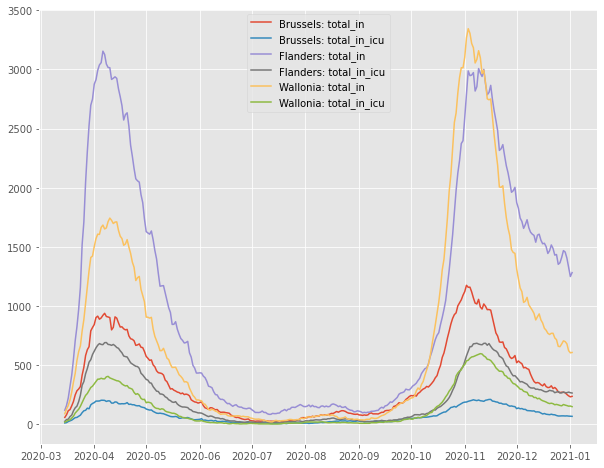

In [27]:
hosp = dict_df["COVID19BE_HOSP"].drop(["PROVINCE"], axis = 1)
summed = hosp.groupby(by=["DATE", "REGION"]).sum()
mult_ind = summed.index.to_frame()
summed["DATE"] = pd.to_datetime(mult_ind.DATE)
summed["REGION"] = mult_ind.REGION.convert_dtypes()
fig, ax = plt.subplots(1, 1)
for e in summed.REGION.unique():
    filtered = summed.filter(like=e, axis = 0)
    ax.plot(filtered.DATE, np.array(filtered.TOTAL_IN), label=f"{e}: total_in")
    ax.plot(filtered.DATE, np.array(filtered.TOTAL_IN_ICU), label=f"{e}: total_in_icu")
ax.legend()

TOTAL_IN  TOTAL_IN_ICU  TOTAL_IN_RESP  TOTAL_IN_ECMO  \
DATE       REGION                                                           
2020-03-15 Brussels        58            11              8              0   
           Flanders       119            25              9              0   
           Wallonia        89            18             15              1   
2020-03-16 Brussels        81            14             11              0   
           Flanders       159            40             20              0   
...                       ...           ...            ...            ...   
2021-01-01 Flanders      1249           267            118             18   
           Wallonia       604           154             87             14   
2021-01-02 Brussels       236            67             42             12   
           Flanders      1282           264             98             14   
           Wallonia       607           149             86             13   

                     NEW_IN  NEW_OUT       DATE    REGION  
DATE       REGION                                          
2020-03-15 Brussels       7        2 2020-03-15  Brussels  
           Flanders      30       14 2020-03-15  Flanders  
           Wallonia      34        2 2020-03-15  Wallonia  
2020-03-16 Brussels      11        4 2020-03-16  Brussels  
           Flanders      45        7 2020-03-16  Flanders  
...                     ...      ...        ...       ...  
2021-01-01 Flanders      76      139 2021-01-01  Flanders  
           Wallonia      58       66 2021-01-01  Wallonia  
2021-01-02 Brussels       7        7 2021-01-02  Brussels  
           Flanders      61       32 2021-01-02  Flanders  
           Wallonia      33       14 2021-01-02  Wallonia  

[882 rows x 8 columns]

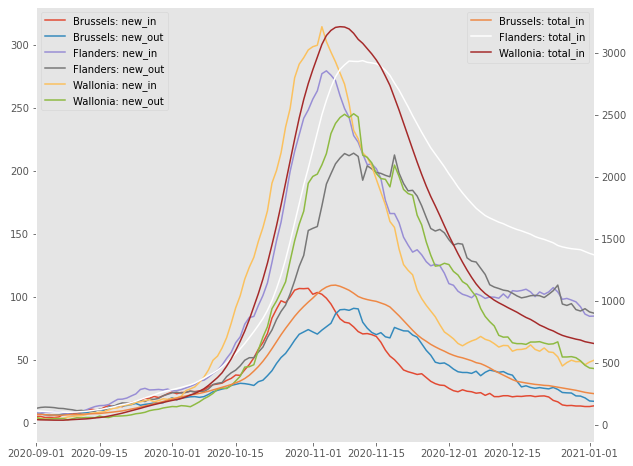

In [45]:
from itertools import cycle
hosp = dict_df["COVID19BE_HOSP"].drop(["PROVINCE"], axis = 1)
summed = hosp.groupby(by=["DATE", "REGION"]).sum()
mult_ind = summed.index.to_frame()
summed["DATE"] = pd.to_datetime(mult_ind.DATE)
summed["REGION"] = mult_ind.REGION.convert_dtypes()
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
colors = cycle(["#EE8845", "white", "brown"])
for e in summed.REGION.unique():
    filtered = summed.filter(like=e, axis = 0)
    # factor = 2 if e == "Flanders" else 3 if e == "Wallonia" else 5 if e = "Brussels" else 7
    ax2.plot(filtered.DATE, filtered.TOTAL_IN.rolling(7, min_periods = 1).mean(), color = next(colors), label=f"{e}: total_in")
    ax.plot(filtered.DATE, filtered.NEW_IN.rolling(7, min_periods = 1).mean(), label=f"{e}: new_in")
    ax.plot(filtered.DATE, filtered.NEW_OUT.rolling(7, min_periods = 1).mean() , label=f"{e}: new_out")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.grid()
ax2.grid()
ax.set_xlim(["2020-09-01", summed.DATE.tail(1)])
summed

In [46]:
%timeit summed[summed.REGION.isin(["Flanders"])] # 600 µs
%timeit filtered = summed.filter(like="Flanders", axis = 0) # 1550 µs

1.43 ms ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
